In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
from grouper import group_by_volume, group_by_time
from pyfolio.timeseries import perf_stats
from functools import partial
from utils import chart_price, plot, v_backtester, c_backtester, perf, perf_var
import sys
sys.path.append('/home/tomek/ib_tools')
from indicators import get_ATR, get_signals
import matplotlib.pyplot as plt
from typing import NamedTuple
from collections import namedtuple
%matplotlib inline

In [2]:
time_int = 45
atr_periods = 80

In [3]:
nq = pd.read_pickle('data/minute_NQ_cont_non_active_included.pickle').loc['20190101':]
es = pd.read_pickle('data/minute_ES_cont_non_active_included.pickle').loc['20190101':]
cl = pd.read_pickle('data/minute_CL_cont_non_active_included.pickle').loc['20190101':]
gc = pd.read_pickle('data/minute_GC_cont_non_active_included.pickle').loc['20190101':]

In [4]:
prices = pd.DataFrame({'nq': nq.close,
                      'es': es.close,
                      'cl': cl.close,
                      'gc': gc.close})
prices = prices.loc['20190125':'20190903']
prices

,nq,es,cl,gc
date,,,,
2019-01-25 00:00:00,6684.50,2637.00,53.19,1285.3
2019-01-25 00:01:00,6683.50,2636.25,53.16,1285.2
2019-01-25 00:02:00,6682.00,2636.00,53.17,1285.2
2019-01-25 00:03:00,6682.50,2636.50,53.20,1285.5
2019-01-25 00:04:00,6683.25,2636.50,53.19,1285.1
...,...,...,...,...
2019-09-03 22:55:00,7619.75,2905.50,53.97,1556.5
2019-09-03 22:56:00,7619.50,2905.50,53.98,1556.7
2019-09-03 22:57:00,7619.75,2905.75,53.96,1556.6


In [5]:
volumes = pd.DataFrame({'nq': nq.volume,
                      'es': es.volume,
                      'cl': cl.volume,
                      'gc': gc.volume})
volumes = volumes.loc['20190125':'20190903']
volumes

,nq,es,cl,gc
date,,,,
2019-01-25 00:00:00,162.0,1143.0,137.0,88.0
2019-01-25 00:01:00,30.0,92.0,58.0,24.0
2019-01-25 00:02:00,48.0,71.0,23.0,42.0
2019-01-25 00:03:00,77.0,85.0,30.0,75.0
2019-01-25 00:04:00,24.0,37.0,97.0,134.0
...,...,...,...,...
2019-09-03 22:55:00,94.0,372.0,204.0,306.0
2019-09-03 22:56:00,79.0,169.0,83.0,74.0
2019-09-03 22:57:00,13.0,96.0,42.0,27.0


In [6]:
avg_vol = volumes.rolling(time_int).sum().mean()
avg_vol

nq    14473.928572
es    43917.958357
cl    18296.080189
gc     8635.326005
dtype: float64

In [7]:
daily = prices.resample('B').last()
daily

,nq,es,cl,gc
date,,,,
2019-01-25,6795.25,2665.50,53.55,1307.9
2019-01-28,6698.75,2640.75,52.09,1307.9
2019-01-29,6681.25,2647.25,53.24,1315.9
2019-01-30,6838.75,2683.25,54.22,1325.0
2019-01-31,6932.50,2712.00,54.02,1325.7
...,...,...,...,...
2019-08-28,7581.75,2883.25,55.90,1548.6
2019-08-29,7706.50,2924.00,56.61,1536.7
2019-08-30,7675.50,2923.75,55.16,1529.2


In [8]:
returns = daily.pct_change().iloc[1:]
stds = returns.std() * np.sqrt(252)
stds

nq    0.177535
es    0.139602
cl    0.291879
gc    0.120305
dtype: float64

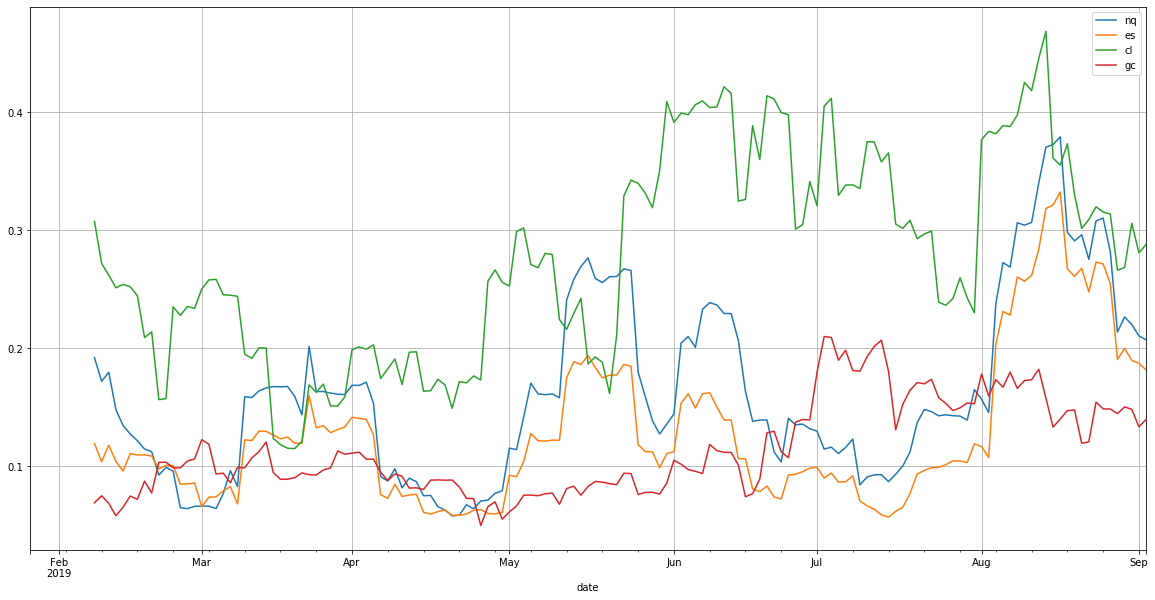

In [18]:
rolling_stds = returns.rolling(10).std() * np.sqrt(252)
rolling_stds.plot(figsize=(20,10), grid=True);

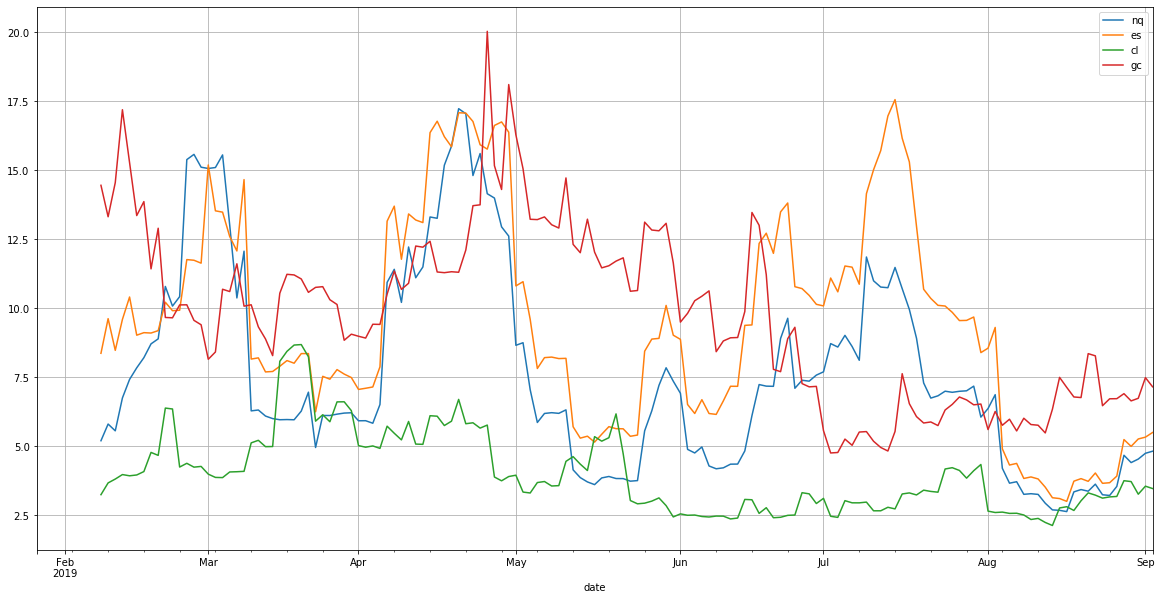

In [20]:
std_adjusted_prices = 1/rolling_stds
std_adjusted_prices.plot(figsize=(20,10), grid=True);

In [12]:
p_to_atr = pd.DataFrame()
for i, n in zip([nq, es, cl, gc], ['nq', 'es', 'cl', 'gc']):
    avg_vol = i.volume.rolling(time_int).sum().mean()
    vol_candles = group_by_volume(i, avg_vol)
    vol_candles['atr'] = get_ATR(vol_candles, atr_periods)
    vol_candles['p_to_atr'] = vol_candles['close'] / vol_candles['atr']
    p_to_atr[n] = vol_candles['p_to_atr']
p_to_atr

,nq,es,cl,gc
label,,,,
0,150.360947,98.940594,108.666667,535.458333
1,122.472613,105.758019,102.850653,547.592445
2,120.002005,94.937664,97.467446,500.953810
3,112.718155,104.064959,90.234437,549.385131
4,107.062058,117.910491,101.893924,532.021838
...,...,...,...,...
5058,312.644619,NaN,164.884165,NaN
5059,316.537482,NaN,165.790687,NaN
5060,320.871966,NaN,166.732577,NaN


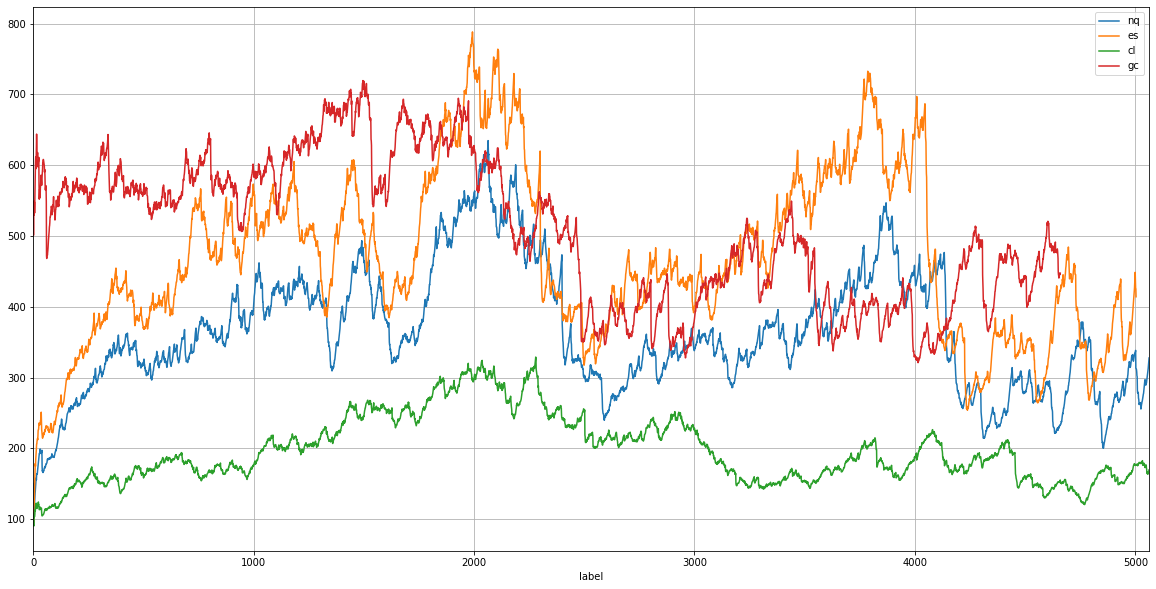

In [15]:
p_to_atr.plot(figsize=(20,10), grid=True);